# Natural Language Processing Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2023 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

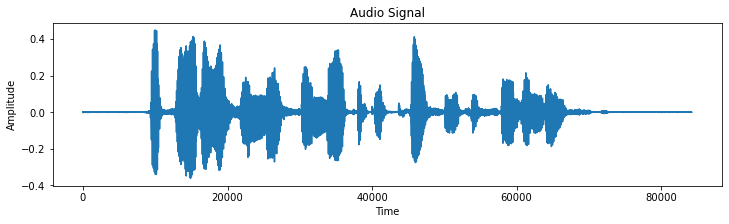

**Shape of Audio Signal** : (84231,)

**Transcript** : her father is a most remarkable person to say the least

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

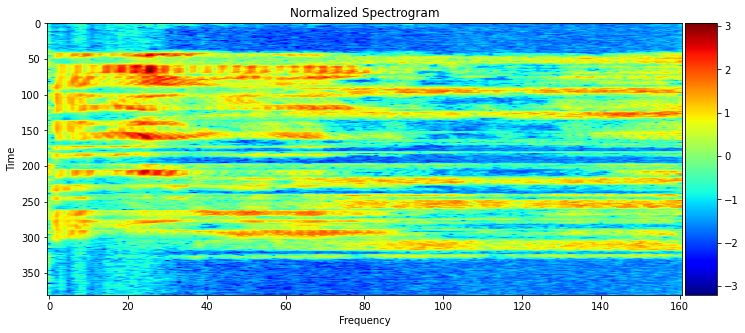

**Shape of Spectrogram** : (381, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : {}'.format(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

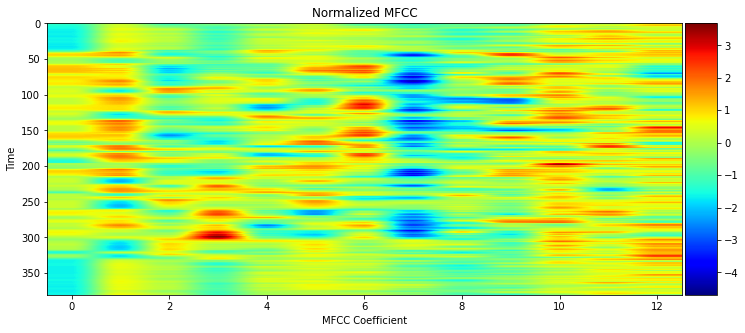

**Shape of MFCC** : (381, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : {}'.format(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [5]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from keras.utils import multi_gpu_model
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
tf.set_random_seed(42)
config = tf.ConfigProto()
set_session(tf.Session(config=config))

from tensorflow.python.client import device_lib
for x in device_lib.list_local_devices():
    if x.device_type == 'GPU':
        print(x.physical_device_desc)

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.


device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [6]:
# change input_dim to 13 if you would like to use MFCC features
m = simple_rnn_model(name='spectrogram_gru', input_dim=161)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [7]:
# change spectrogram to False if you would like to use MFCC features
train_model(input_to_softmax=m, pickle_path=f'm0_{m.name}.pickle', save_model_path=f'm0_{m.name}.h5', spectrogram=True)

Epoch 1/20
101/101 [==============================] - 100s 986ms/step - loss: 857.9460 - val_loss: 757.5454
Epoch 2/20
101/101 [==============================] - 103s 1s/step - loss: 779.4186 - val_loss: 764.0196
Epoch 3/20
101/101 [==============================] - 117s 1s/step - loss: 777.5798 - val_loss: 757.3294
Epoch 4/20
101/101 [==============================] - 116s 1s/step - loss: 778.1797 - val_loss: 750.6053
Epoch 5/20
101/101 [==============================] - 122s 1s/step - loss: 777.6877 - val_loss: 762.3941
Epoch 6/20
101/101 [==============================] - 127s 1s/step - loss: 778.1106 - val_loss: 757.8352
Epoch 7/20
101/101 [==============================] - 124s 1s/step - loss: 778.1839 - val_loss: 759.0473
Epoch 8/20
101/101 [==============================] - 118s 1s/step - loss: 778.0519 - val_loss: 755.5296
Epoch 9/20
101/101 [==============================] - 124s 1s/step - loss: 778.2257 - val_loss: 761.2387
Epoch 10/20
101/101 [==============================]

In [8]:
# change input_dim to 161 if you would like to use Spectrogram features
m = simple_rnn_model(name='mfcc_gru', input_dim=13)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm0_{m.name}.pickle', save_model_path=f'm0_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 121s 1s/step - loss: 848.2164 - val_loss: 756.7282
Epoch 2/20
101/101 [==============================] - 131s 1s/step - loss: 780.0338 - val_loss: 761.0852
Epoch 3/20
101/101 [==============================] - 135s 1s/step - loss: 779.5567 - val_loss: 757.1773
Epoch 4/20
101/101 [==============================] - 135s 1s/step - loss: 779.6708 - val_loss: 753.3891
Epoch 5/20
101/101 [==============================] - 136s 1s/step - loss: 779.1349 - val_loss: 759.4455
Epoch 6/20
101/101 [==============================] - 135s 1s/step - loss: 779.4374 - val_loss: 756.5201
Epoch 7/20
101/101 [==============================] - 149s 1s/step - loss: 778.8119 - val_loss: 761.1704
Epoch 8/20
101/101 [==============================] - 133s 1s/step - loss: 779.3489 - val_loss: 751.5755
Epoch 9/20
101/101 [==============================] - 133s 1s/step - loss: 778.4813 - val_loss: 759.2783
Epoch 10/20
101/101 [==============================] - 

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistributed`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `m` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [10]:
# change input_dim to 161 if you would like to use Spectrogram features
m = rnn_model(name='mfcc_gru_relu_u256_l1_dense', input_dim=13, rnn_act='relu', units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         207360    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 215,837
Trainable params: 215,325
Non-trainable params: 512
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `f'm1_{m.name}.h5'`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `f'm1_{m.name}.pickle'`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [11]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm1_{m.name}.pickle', save_model_path=f'm1_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 154s 2s/step - loss: 317.7546 - val_loss: 270.7976
Epoch 2/20
101/101 [==============================] - 164s 2s/step - loss: 229.1162 - val_loss: 247.4580
Epoch 3/20
101/101 [==============================] - 161s 2s/step - loss: 203.9189 - val_loss: 205.2322
Epoch 4/20
101/101 [==============================] - 166s 2s/step - loss: 188.6919 - val_loss: 186.3217
Epoch 5/20
101/101 [==============================] - 171s 2s/step - loss: 176.3338 - val_loss: 176.5115
Epoch 6/20
101/101 [==============================] - 166s 2s/step - loss: 166.0758 - val_loss: 162.8507
Epoch 7/20
101/101 [==============================] - 162s 2s/step - loss: 156.7472 - val_loss: 161.8203
Epoch 8/20
101/101 [==============================] - 161s 2s/step - loss: 149.4661 - val_loss: 151.2661
Epoch 9/20
101/101 [==============================] - 174s 2s/step - loss: 143.7324 - val_loss: 151.4717
Epoch 10/20
101/101 [==============================] - 

In [12]:
# change input_dim to 161 if you would like to use Spectrogram features
m = rnn_model(name='mfcc_gru_tanh_u256_l1_dense', input_dim=13, rnn_act='tanh', units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         207360    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 215,837
Trainable params: 215,325
Non-trainable params: 512
_________________________________________________________________
None


In [13]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm1_{m.name}.pickle', save_model_path=f'm1_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 157s 2s/step - loss: 347.3013 - val_loss: 267.7100
Epoch 2/20
101/101 [==============================] - 176s 2s/step - loss: 238.3945 - val_loss: 220.5727
Epoch 3/20
101/101 [==============================] - 180s 2s/step - loss: 220.1986 - val_loss: 207.1824
Epoch 4/20
101/101 [==============================] - 180s 2s/step - loss: 209.8376 - val_loss: 201.4160
Epoch 5/20
101/101 [==============================] - 172s 2s/step - loss: 200.3990 - val_loss: 186.3870
Epoch 6/20
101/101 [==============================] - 170s 2s/step - loss: 189.9797 - val_loss: 182.0854
Epoch 7/20
101/101 [==============================] - 182s 2s/step - loss: 179.5462 - val_loss: 176.3153
Epoch 8/20
101/101 [==============================] - 170s 2s/step - loss: 169.6579 - val_loss: 170.2359
Epoch 9/20
101/101 [==============================] - 176s 2s/step - loss: 161.3578 - val_loss: 158.5135
Epoch 10/20
101/101 [==============================] - 

In [14]:
# change input_dim to 161 if you would like to use Spectrogram features
m = rnn_model(name='mfcc_gru_relu_u512_l1_dense', input_dim=13, rnn_act='relu', units=512)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 512)         807936    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 512)         2048      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          14877     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 824,861
Trainable params: 823,837
Non-trainable params: 1,024
_________________________________________________________________
None


In [15]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm1_{m.name}.pickle', save_model_path=f'm1_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 243s 2s/step - loss: 417.7549 - val_loss: 404.6266
Epoch 2/20
101/101 [==============================] - 247s 2s/step - loss: 265.5267 - val_loss: 275.9219
Epoch 3/20
101/101 [==============================] - 255s 3s/step - loss: 227.7625 - val_loss: 215.0891
Epoch 4/20
101/101 [==============================] - 258s 3s/step - loss: 206.1328 - val_loss: 205.6819
Epoch 5/20
101/101 [==============================] - 259s 3s/step - loss: 182.6831 - val_loss: 178.8526
Epoch 6/20
101/101 [==============================] - 257s 3s/step - loss: 168.7294 - val_loss: 166.2359
Epoch 7/20
101/101 [==============================] - 266s 3s/step - loss: 160.8037 - val_loss: 158.8164
Epoch 8/20
101/101 [==============================] - 253s 3s/step - loss: 153.2569 - val_loss: 155.6335
Epoch 9/20
101/101 [==============================] - 264s 3s/step - loss: 146.6686 - val_loss: 152.2926
Epoch 10/20
101/101 [==============================] - 

In [16]:
# change input_dim to 161 if you would like to use Spectrogram features
m = rnn_model(name='mfcc_gru_relu_u128_l1_dense', input_dim=13, rnn_act='relu', units=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 128)         54528     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 128)         512       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 58,781
Trainable params: 58,525
Non-trainable params: 256
_________________________________________________________________
None


In [17]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm1_{m.name}.pickle', save_model_path=f'm1_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 126s 1s/step - loss: 298.7321 - val_loss: 247.6288
Epoch 2/20
101/101 [==============================] - 124s 1s/step - loss: 223.0738 - val_loss: 214.0078
Epoch 3/20
101/101 [==============================] - 127s 1s/step - loss: 200.6449 - val_loss: 193.5029
Epoch 4/20
101/101 [==============================] - 128s 1s/step - loss: 183.9330 - val_loss: 177.3129
Epoch 5/20
101/101 [==============================] - 122s 1s/step - loss: 171.6865 - val_loss: 172.5015
Epoch 6/20
101/101 [==============================] - 127s 1s/step - loss: 162.4327 - val_loss: 160.5508
Epoch 7/20
101/101 [==============================] - 123s 1s/step - loss: 155.5136 - val_loss: 161.1281
Epoch 8/20
101/101 [==============================] - 123s 1s/step - loss: 151.0575 - val_loss: 153.3799
Epoch 9/20
101/101 [==============================] - 120s 1s/step - loss: 146.9837 - val_loss: 150.3371
Epoch 10/20
101/101 [==============================] - 

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [18]:
# change input_dim to 161 if you would like to use Spectrogram features
m = cnn_rnn_model(name='mfcc_cnn_f256_k11_l1_gru_dense', input_dim=13, filters=256, kernel_size=11,
                  conv_stride=2, conv_border_mode='valid', conv_act='relu', units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 256)         36864     
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         393984    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `f'm2_{m.name}.h5'`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `f'm2_{m.name}.pickle'`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [19]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm2_{m.name}.pickle', save_model_path=f'm2_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 100s 988ms/step - loss: 251.5984 - val_loss: 223.5317
Epoch 2/20
101/101 [==============================] - 95s 945ms/step - loss: 191.3230 - val_loss: 172.1372
Epoch 3/20
101/101 [==============================] - 96s 946ms/step - loss: 159.8282 - val_loss: 151.1486
Epoch 4/20
101/101 [==============================] - 94s 930ms/step - loss: 141.6135 - val_loss: 142.9894
Epoch 5/20
101/101 [==============================] - 93s 919ms/step - loss: 129.8683 - val_loss: 139.3325
Epoch 6/20
101/101 [==============================] - 95s 941ms/step - loss: 121.6073 - val_loss: 136.6704
Epoch 7/20
101/101 [==============================] - 96s 951ms/step - loss: 114.6261 - val_loss: 132.4060
Epoch 8/20
101/101 [==============================] - 96s 949ms/step - loss: 108.9984 - val_loss: 130.4079
Epoch 9/20
101/101 [==============================] - 94s 932ms/step - loss: 103.3006 - val_loss: 128.8066
Epoch 10/20
101/101 [===============

In [20]:
# change input_dim to 161 if you would like to use Spectrogram features
m = cnn_rnn_model(name='mfcc_cnn_f256_k13_l1_gru_dense', input_dim=13, filters=256, kernel_size=13,
                  conv_stride=2, conv_border_mode='valid', conv_act='relu', units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 256)         43520     
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         393984    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [21]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm2_{m.name}.pickle', save_model_path=f'm2_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 99s 976ms/step - loss: 245.3610 - val_loss: 216.4915
Epoch 2/20
101/101 [==============================] - 95s 944ms/step - loss: 180.4728 - val_loss: 162.4581
Epoch 3/20
101/101 [==============================] - 96s 948ms/step - loss: 153.2931 - val_loss: 154.6421
Epoch 4/20
101/101 [==============================] - 96s 955ms/step - loss: 138.5316 - val_loss: 142.0934
Epoch 5/20
101/101 [==============================] - 95s 942ms/step - loss: 128.0868 - val_loss: 137.6443
Epoch 6/20
101/101 [==============================] - 94s 928ms/step - loss: 120.0818 - val_loss: 134.8163
Epoch 7/20
101/101 [==============================] - 95s 938ms/step - loss: 113.3957 - val_loss: 132.5510
Epoch 8/20
101/101 [==============================] - 95s 941ms/step - loss: 107.6017 - val_loss: 130.1179
Epoch 9/20
101/101 [==============================] - 95s 943ms/step - loss: 102.5445 - val_loss: 131.9666
Epoch 10/20
101/101 [================

In [22]:
# change input_dim to 161 if you would like to use Spectrogram features
m = cnn_rnn_model(name='mfcc_cnn_f256_k9_l1_gru_dense', input_dim=13, filters=256, kernel_size=9,
                  conv_stride=2, conv_border_mode='valid', conv_act='relu', units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 256)         30208     
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         393984    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [23]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm2_{m.name}.pickle', save_model_path=f'm2_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 99s 981ms/step - loss: 242.8236 - val_loss: 215.2274
Epoch 2/20
101/101 [==============================] - 96s 951ms/step - loss: 180.8138 - val_loss: 163.9413
Epoch 3/20
101/101 [==============================] - 97s 956ms/step - loss: 153.0648 - val_loss: 147.1164
Epoch 4/20
101/101 [==============================] - 97s 958ms/step - loss: 137.3623 - val_loss: 140.1385
Epoch 5/20
101/101 [==============================] - 96s 948ms/step - loss: 126.7902 - val_loss: 137.6284
Epoch 6/20
101/101 [==============================] - 95s 936ms/step - loss: 119.1358 - val_loss: 134.6170
Epoch 7/20
101/101 [==============================] - 96s 950ms/step - loss: 112.5476 - val_loss: 132.0843
Epoch 8/20
101/101 [==============================] - 95s 944ms/step - loss: 106.7425 - val_loss: 126.9981
Epoch 9/20
101/101 [==============================] - 96s 949ms/step - loss: 101.7130 - val_loss: 128.1328
Epoch 10/20
101/101 [================

In [24]:
# change input_dim to 161 if you would like to use Spectrogram features
m = cnn_rnn_model(name='mfcc_cnn_f256_k7_l1_gru_dense', input_dim=13, filters=256, kernel_size=7,
                  conv_stride=2, conv_border_mode='valid', conv_act='relu', units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 256)         23552     
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         393984    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [25]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm2_{m.name}.pickle', save_model_path=f'm2_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 98s 971ms/step - loss: 242.7324 - val_loss: 216.3424
Epoch 2/20
101/101 [==============================] - 95s 942ms/step - loss: 185.1108 - val_loss: 168.0793
Epoch 3/20
101/101 [==============================] - 96s 950ms/step - loss: 155.6656 - val_loss: 150.2185
Epoch 4/20
101/101 [==============================] - 95s 937ms/step - loss: 140.4968 - val_loss: 145.9891
Epoch 5/20
101/101 [==============================] - 95s 943ms/step - loss: 129.7436 - val_loss: 141.0258
Epoch 6/20
101/101 [==============================] - 95s 939ms/step - loss: 121.6908 - val_loss: 135.4456
Epoch 7/20
101/101 [==============================] - 95s 938ms/step - loss: 115.2519 - val_loss: 135.0405
Epoch 8/20
101/101 [==============================] - 94s 928ms/step - loss: 109.1826 - val_loss: 129.8302
Epoch 9/20
101/101 [==============================] - 94s 934ms/step - loss: 104.3756 - val_loss: 130.8704
Epoch 10/20
101/101 [================

In [26]:
# change input_dim to 161 if you would like to use Spectrogram features
m = cnn_rnn_model(name='mfcc_cnn_f256_k5_l1_gru_dense', input_dim=13, filters=256, kernel_size=5,
                  conv_stride=2, conv_border_mode='valid', conv_act='relu', units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
cnn (Conv1D)                 (None, None, 256)         16896     
_________________________________________________________________
bn_cnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         393984    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [27]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm2_{m.name}.pickle', save_model_path=f'm2_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 100s 993ms/step - loss: 248.7251 - val_loss: 234.2624
Epoch 2/20
101/101 [==============================] - 95s 942ms/step - loss: 193.8092 - val_loss: 173.9698
Epoch 3/20
101/101 [==============================] - 96s 953ms/step - loss: 164.5899 - val_loss: 161.2150
Epoch 4/20
101/101 [==============================] - 94s 933ms/step - loss: 146.6169 - val_loss: 145.5715
Epoch 5/20
101/101 [==============================] - 96s 949ms/step - loss: 134.9116 - val_loss: 141.9503
Epoch 6/20
101/101 [==============================] - 96s 950ms/step - loss: 126.3997 - val_loss: 137.6018
Epoch 7/20
101/101 [==============================] - 98s 966ms/step - loss: 119.2950 - val_loss: 132.7579
Epoch 8/20
101/101 [==============================] - 97s 959ms/step - loss: 113.1244 - val_loss: 133.5138
Epoch 9/20
101/101 [==============================] - 96s 947ms/step - loss: 107.8655 - val_loss: 129.8474
Epoch 10/20
101/101 [===============

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `rnn_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `rnn_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `rnn_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `rnn_layers=1`.)

In [28]:
# change input_dim to 161 if you would like to use Spectrogram features
m = deep_rnn_model(name='mfcc_gru_relu_u256_l2_dense', input_dim=13, rnn_layers=2, units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 256)         207360    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 256)         393984    
_________________________________________________________________
bn_rnn_2 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `f'm3_{m.name}.h5'`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `f'm3_{m.name}.pickle'`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [29]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm3_{m.name}.pickle', save_model_path=f'm3_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 235s 2s/step - loss: 279.7984 - val_loss: 230.1197
Epoch 2/20
101/101 [==============================] - 253s 3s/step - loss: 231.0264 - val_loss: 215.0730
Epoch 3/20
101/101 [==============================] - 235s 2s/step - loss: 217.5891 - val_loss: 215.4701
Epoch 4/20
101/101 [==============================] - 251s 2s/step - loss: 189.5748 - val_loss: 174.7684
Epoch 5/20
101/101 [==============================] - 239s 2s/step - loss: 163.3577 - val_loss: 157.9927
Epoch 6/20
101/101 [==============================] - 251s 2s/step - loss: 150.2886 - val_loss: 154.4456
Epoch 7/20
101/101 [==============================] - 248s 2s/step - loss: 143.1523 - val_loss: 146.8110
Epoch 8/20
101/101 [==============================] - 244s 2s/step - loss: 135.9402 - val_loss: 142.7479
Epoch 9/20
101/101 [==============================] - 250s 2s/step - loss: 131.2856 - val_loss: 140.7115
Epoch 10/20
101/101 [==============================] - 

In [30]:
# change input_dim to 161 if you would like to use Spectrogram features
m = deep_rnn_model(name='mfcc_gru_relu_u256_l3_dense', input_dim=13, rnn_layers=3, units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 256)         207360    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 256)         393984    
_________________________________________________________________
bn_rnn_2 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
rnn_3 (GRU)                  (None, None, 256)         393984    
_________________________________________________________________
bn_rnn_3 (BatchNormalization (None, None, 256)         1024      
__________

In [31]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm3_{m.name}.pickle', save_model_path=f'm3_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 534s 5s/step - loss: 270.6999 - val_loss: 231.0800
Epoch 2/20
101/101 [==============================] - 540s 5s/step - loss: 226.9683 - val_loss: 209.8654
Epoch 3/20
101/101 [==============================] - 560s 6s/step - loss: 205.9132 - val_loss: 193.0703
Epoch 4/20
101/101 [==============================] - 537s 5s/step - loss: 178.5075 - val_loss: 167.7069
Epoch 5/20
101/101 [==============================] - 548s 5s/step - loss: 155.3753 - val_loss: 152.2560
Epoch 6/20
101/101 [==============================] - 551s 5s/step - loss: 142.4038 - val_loss: 150.2188
Epoch 7/20
101/101 [==============================] - 536s 5s/step - loss: 132.9431 - val_loss: 140.7567
Epoch 8/20
101/101 [==============================] - 528s 5s/step - loss: 126.1347 - val_loss: 140.8419
Epoch 9/20
101/101 [==============================] - 545s 5s/step - loss: 120.4156 - val_loss: 133.7848
Epoch 10/20
101/101 [==============================] - 

In [32]:
# change input_dim to 161 if you would like to use Spectrogram features
m = deep_rnn_model(name='mfcc_gru_relu_u512_l2_dense', input_dim=13, rnn_layers=2, units=512)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 512)         807936    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 512)         2048      
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 512)         1574400   
_________________________________________________________________
bn_rnn_2 (BatchNormalization (None, None, 512)         2048      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          14877     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [33]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm3_{m.name}.pickle', save_model_path=f'm3_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 705s 7s/step - loss: 288.5010 - val_loss: 242.9244
Epoch 2/20
101/101 [==============================] - 765s 8s/step - loss: 236.5008 - val_loss: 212.5780
Epoch 3/20
101/101 [==============================] - 761s 8s/step - loss: 205.3020 - val_loss: 194.2222
Epoch 4/20
101/101 [==============================] - 725s 7s/step - loss: 179.4218 - val_loss: 165.3466
Epoch 5/20
101/101 [==============================] - 708s 7s/step - loss: 159.1166 - val_loss: 166.3570
Epoch 6/20
101/101 [==============================] - 739s 7s/step - loss: 145.9212 - val_loss: 149.6328
Epoch 7/20
101/101 [==============================] - 731s 7s/step - loss: 136.2984 - val_loss: 145.2705
Epoch 8/20
101/101 [==============================] - 711s 7s/step - loss: 128.3464 - val_loss: 144.4215
Epoch 9/20
101/101 [==============================] - 701s 7s/step - loss: 121.8576 - val_loss: 139.9314
Epoch 10/20
101/101 [==============================] - 

In [34]:
# change input_dim to 161 if you would like to use Spectrogram features
m = deep_rnn_model(name='mfcc_gru_relu_u128_l2_dense', input_dim=13, rnn_layers=2, units=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 128)         54528     
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 128)         512       
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
bn_rnn_2 (BatchNormalization (None, None, 128)         512       
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [35]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm3_{m.name}.pickle', save_model_path=f'm3_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 275s 3s/step - loss: 296.9637 - val_loss: 229.0779
Epoch 2/20
101/101 [==============================] - 277s 3s/step - loss: 211.8949 - val_loss: 193.0278
Epoch 3/20
101/101 [==============================] - 267s 3s/step - loss: 182.6041 - val_loss: 172.1397
Epoch 4/20
101/101 [==============================] - 268s 3s/step - loss: 166.1335 - val_loss: 166.8053
Epoch 5/20
101/101 [==============================] - 269s 3s/step - loss: 156.0697 - val_loss: 160.0877
Epoch 6/20
101/101 [==============================] - 274s 3s/step - loss: 149.3681 - val_loss: 150.3142
Epoch 7/20
101/101 [==============================] - 273s 3s/step - loss: 143.2185 - val_loss: 147.9321
Epoch 8/20
101/101 [==============================] - 268s 3s/step - loss: 138.4608 - val_loss: 146.4735
Epoch 9/20
101/101 [==============================] - 271s 3s/step - loss: 135.1056 - val_loss: 142.6820
Epoch 10/20
101/101 [==============================] - 

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [36]:
# change input_dim to 161 if you would like to use Spectrogram features
m = bidirectional_rnn_model(name='mfcc_gru_relu_u256_l1_bd_dense', input_dim=13, units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bd_rnn (Bidirectional)       (None, None, 512)         414720    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 512)         2048      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          14877     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 431,645
Trainable params: 430,621
Non-trainable params: 1,024
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `f'm4_{m.name}.h5'`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `f'm4_{m.name}.pickle'`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [37]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm4_{m.name}.pickle', save_model_path=f'm4_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 226s 2s/step - loss: 316.8930 - val_loss: 250.3390
Epoch 2/20
101/101 [==============================] - 244s 2s/step - loss: 233.8913 - val_loss: 228.5122
Epoch 3/20
101/101 [==============================] - 252s 2s/step - loss: 204.6591 - val_loss: 199.6166
Epoch 4/20
101/101 [==============================] - 245s 2s/step - loss: 189.5364 - val_loss: 198.8653
Epoch 5/20
101/101 [==============================] - 241s 2s/step - loss: 178.7594 - val_loss: 174.7736
Epoch 6/20
101/101 [==============================] - 252s 2s/step - loss: 168.4936 - val_loss: 166.7040
Epoch 7/20
101/101 [==============================] - 266s 3s/step - loss: 159.9002 - val_loss: 158.7380
Epoch 8/20
101/101 [==============================] - 258s 3s/step - loss: 152.3486 - val_loss: 162.0283
Epoch 9/20
101/101 [==============================] - 268s 3s/step - loss: 145.6423 - val_loss: 149.0035
Epoch 10/20
101/101 [==============================] - 

In [38]:
# change input_dim to 161 if you would like to use Spectrogram features
m = bidirectional_rnn_model(name='mfcc_gru_relu_u512_l1_bd_dense', input_dim=13, units=512)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bd_rnn (Bidirectional)       (None, None, 1024)        1615872   
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 1024)        4096      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          29725     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 1,649,693
Trainable params: 1,647,645
Non-trainable params: 2,048
_________________________________________________________________
None


In [39]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm4_{m.name}.pickle', save_model_path=f'm4_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 754s 7s/step - loss: 321.7897 - val_loss: 283.3041
Epoch 2/20
101/101 [==============================] - 738s 7s/step - loss: 247.7604 - val_loss: 268.9361
Epoch 3/20
101/101 [==============================] - 775s 8s/step - loss: 207.7936 - val_loss: 266.6108
Epoch 4/20
101/101 [==============================] - 787s 8s/step - loss: 191.5901 - val_loss: 202.8439
Epoch 5/20
101/101 [==============================] - 807s 8s/step - loss: 181.5276 - val_loss: 177.5159
Epoch 6/20
101/101 [==============================] - 789s 8s/step - loss: 173.8344 - val_loss: 180.6083
Epoch 7/20
101/101 [==============================] - 780s 8s/step - loss: 166.6986 - val_loss: 175.9719
Epoch 8/20
101/101 [==============================] - 704s 7s/step - loss: 160.6326 - val_loss: 172.5248
Epoch 9/20
101/101 [==============================] - 666s 7s/step - loss: 155.4408 - val_loss: 168.8983
Epoch 10/20
101/101 [==============================] - 

In [40]:
# change input_dim to 161 if you would like to use Spectrogram features
m = bidirectional_rnn_model(name='mfcc_gru_relu_u128_l1_bd_dense', input_dim=13, units=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bd_rnn (Bidirectional)       (None, None, 256)         109056    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense (TimeDistributed)   (None, None, 29)          7453      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 117,533
Trainable params: 117,021
Non-trainable params: 512
_________________________________________________________________
None


In [41]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm4_{m.name}.pickle', save_model_path=f'm4_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 211s 2s/step - loss: 296.7744 - val_loss: 238.8732
Epoch 2/20
101/101 [==============================] - 210s 2s/step - loss: 230.9049 - val_loss: 218.9836
Epoch 3/20
101/101 [==============================] - 210s 2s/step - loss: 205.2744 - val_loss: 194.6967
Epoch 4/20
101/101 [==============================] - 214s 2s/step - loss: 185.3797 - val_loss: 178.6151
Epoch 5/20
101/101 [==============================] - 213s 2s/step - loss: 173.1431 - val_loss: 171.1630
Epoch 6/20
101/101 [==============================] - 210s 2s/step - loss: 163.8179 - val_loss: 165.1724
Epoch 7/20
101/101 [==============================] - 213s 2s/step - loss: 155.3337 - val_loss: 158.6843
Epoch 8/20
101/101 [==============================] - 213s 2s/step - loss: 148.5371 - val_loss: 153.9377
Epoch 9/20
101/101 [==============================] - 211s 2s/step - loss: 143.3413 - val_loss: 150.1330
Epoch 10/20
101/101 [==============================] - 

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`f'mi_{m.name}.pickle'`** and saving the trained model at **`f'mi_{m.name}.h5'`**.

In [42]:
# change input_dim to 161 if you would like to use Spectrogram features
m = tail_rnn_model(name='mfcc_gru_dense_u256_l2', input_dim=13, dense_layers=2, dense_act='relu', dense_units=256, units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         207360    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense_1 (TimeDistributed) (None, None, 256)         65792     
_________________________________________________________________
dp_dense_1 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
bn_dense_1 (BatchNormalizati (None, None, 256)         1024      
_________________________________________________________________
td_dense_2 (TimeDistributed) (None, None, 29)          7453      
__________

In [43]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm5_{m.name}.pickle', save_model_path=f'm5_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 147s 1s/step - loss: 302.1417 - val_loss: 267.1873
Epoch 2/20
101/101 [==============================] - 156s 2s/step - loss: 222.0345 - val_loss: 203.8515
Epoch 3/20
101/101 [==============================] - 184s 2s/step - loss: 205.5465 - val_loss: 197.8921
Epoch 4/20
101/101 [==============================] - 183s 2s/step - loss: 192.4520 - val_loss: 194.2370
Epoch 5/20
101/101 [==============================] - 168s 2s/step - loss: 182.0184 - val_loss: 175.4367
Epoch 6/20
101/101 [==============================] - 177s 2s/step - loss: 173.1611 - val_loss: 163.9532
Epoch 7/20
101/101 [==============================] - 171s 2s/step - loss: 164.8071 - val_loss: 157.3358
Epoch 8/20
101/101 [==============================] - 164s 2s/step - loss: 156.3533 - val_loss: 154.8897
Epoch 9/20
101/101 [==============================] - 174s 2s/step - loss: 149.0655 - val_loss: 146.4105
Epoch 10/20
101/101 [==============================] - 

In [44]:
# change input_dim to 161 if you would like to use Spectrogram features
m = tail_rnn_model(name='mfcc_gru_dense_u512_l2', input_dim=13, dense_layers=2, dense_act='relu', dense_units=512, units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         207360    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense_1 (TimeDistributed) (None, None, 512)         131584    
_________________________________________________________________
dp_dense_1 (Dropout)         (None, None, 512)         0         
_________________________________________________________________
bn_dense_1 (BatchNormalizati (None, None, 512)         2048      
_________________________________________________________________
td_dense_2 (TimeDistributed) (None, None, 29)          14877     
__________

In [45]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm5_{m.name}.pickle', save_model_path=f'm5_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 158s 2s/step - loss: 300.1888 - val_loss: 236.3671
Epoch 2/20
101/101 [==============================] - 181s 2s/step - loss: 228.7292 - val_loss: 207.3666
Epoch 3/20
101/101 [==============================] - 161s 2s/step - loss: 212.2777 - val_loss: 194.5097
Epoch 4/20
101/101 [==============================] - 184s 2s/step - loss: 197.0644 - val_loss: 192.0108
Epoch 5/20
101/101 [==============================] - 186s 2s/step - loss: 186.1960 - val_loss: 172.3999
Epoch 6/20
101/101 [==============================] - 182s 2s/step - loss: 176.8739 - val_loss: 169.8003
Epoch 7/20
101/101 [==============================] - 174s 2s/step - loss: 168.2882 - val_loss: 159.5507
Epoch 8/20
101/101 [==============================] - 172s 2s/step - loss: 160.5825 - val_loss: 153.6869
Epoch 9/20
101/101 [==============================] - 168s 2s/step - loss: 153.8876 - val_loss: 149.4861
Epoch 10/20
101/101 [==============================] - 

In [46]:
# change input_dim to 161 if you would like to use Spectrogram features
m = tail_rnn_model(name='mfcc_gru_dense_u128_l2', input_dim=13, dense_layers=2, dense_act='relu', dense_units=128, units=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 256)         207360    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 256)         1024      
_________________________________________________________________
td_dense_1 (TimeDistributed) (None, None, 128)         32896     
_________________________________________________________________
dp_dense_1 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bn_dense_1 (BatchNormalizati (None, None, 128)         512       
_________________________________________________________________
td_dense_2 (TimeDistributed) (None, None, 29)          3741      
__________

In [47]:
# change spectrogram to True if you would like to use Spectrogram features
train_model(input_to_softmax=m, pickle_path=f'm5_{m.name}.pickle', save_model_path=f'm5_{m.name}.h5', spectrogram=False)

Epoch 1/20
101/101 [==============================] - 134s 1s/step - loss: 288.2661 - val_loss: 244.3268
Epoch 2/20
101/101 [==============================] - 162s 2s/step - loss: 218.3986 - val_loss: 204.3062
Epoch 3/20
101/101 [==============================] - 166s 2s/step - loss: 204.3646 - val_loss: 204.9208
Epoch 4/20
101/101 [==============================] - 162s 2s/step - loss: 192.8665 - val_loss: 188.6416
Epoch 5/20
101/101 [==============================] - 162s 2s/step - loss: 183.4629 - val_loss: 173.0911
Epoch 6/20
101/101 [==============================] - 170s 2s/step - loss: 175.5348 - val_loss: 171.6747
Epoch 7/20
101/101 [==============================] - 177s 2s/step - loss: 167.7822 - val_loss: 158.3811
Epoch 8/20
101/101 [==============================] - 176s 2s/step - loss: 160.6646 - val_loss: 154.2257
Epoch 9/20
101/101 [==============================] - 172s 2s/step - loss: 154.0849 - val_loss: 151.3531
Epoch 10/20
101/101 [==============================] - 

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

In [48]:
import numpy as np
np.random.seed(42)

import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')


def compare_models(model_paths):

    # extract the name of each model
    model_names = [item[8:-7] for item in model_paths]
    # extract the loss history for each model
    valid_loss = [pickle.load(open(i, 'rb'))['val_loss'] for i in model_paths]
    train_loss = [pickle.load(open(i, 'rb'))['loss'] for i in model_paths]
    # save the number of epochs used to train each model
    num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

    # plot the training loss vs. epoch for each model
    fig = plt.figure(figsize=(16, 5))
    ax1 = fig.add_subplot(121)
    for i in range(len(model_paths)):
        ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), train_loss[i], label=model_names[i])
    # clean up the plot
    ax1.legend()
    ax1.set_xlim([1, max(num_epochs)])
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')

    # plot the validation loss vs. epoch for each model
    ax2 = fig.add_subplot(122)
    for i in range(len(model_paths)):
        ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), valid_loss[i], label=model_names[i])
    # clean up the plot
    ax2.legend()
    ax2.set_xlim([1, max(num_epochs)])
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.show()

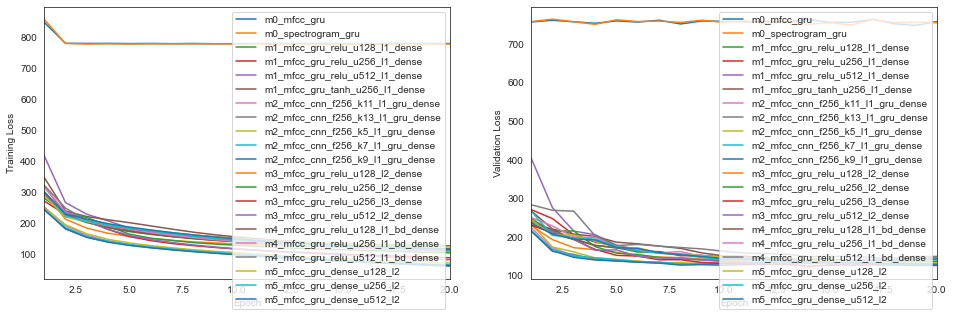

In [49]:
import os
from glob import glob

# obtain the paths for the saved model history
all_pickles = sorted(glob(os.path.join('results','*.pickle')))
# plot all evaluated rnn models
compare_models([m for m in all_pickles if any(x in m for x in ['m0', 'm1', 'm2', 'm3', 'm4', 'm5'])])

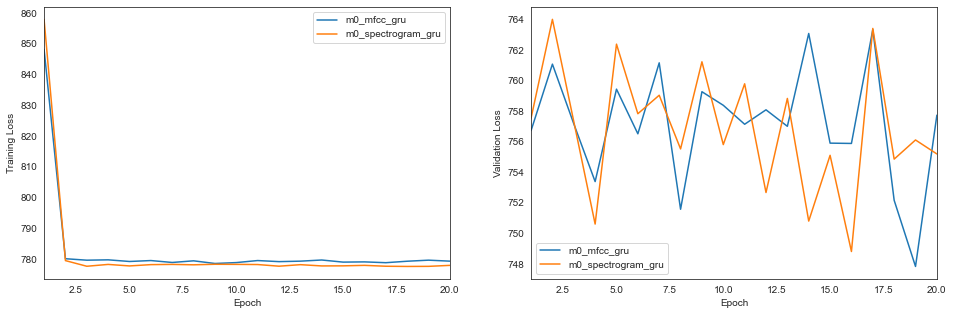

In [50]:
# plot model 0 variants
compare_models([m for m in all_pickles if 'm0' in m])

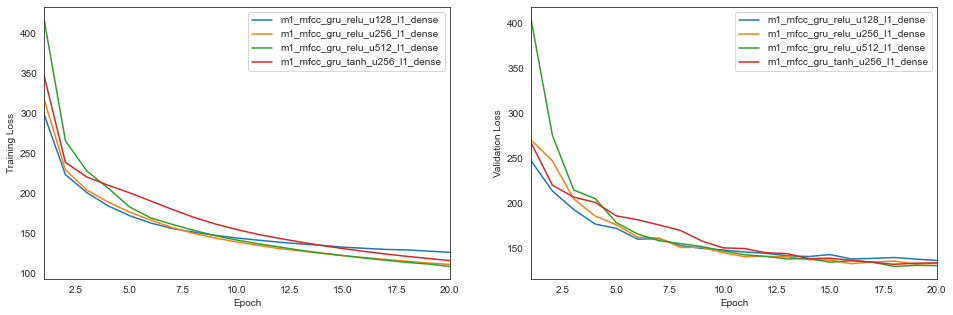

In [51]:
# plot model 1 variants
compare_models([m for m in all_pickles if 'm1' in m])

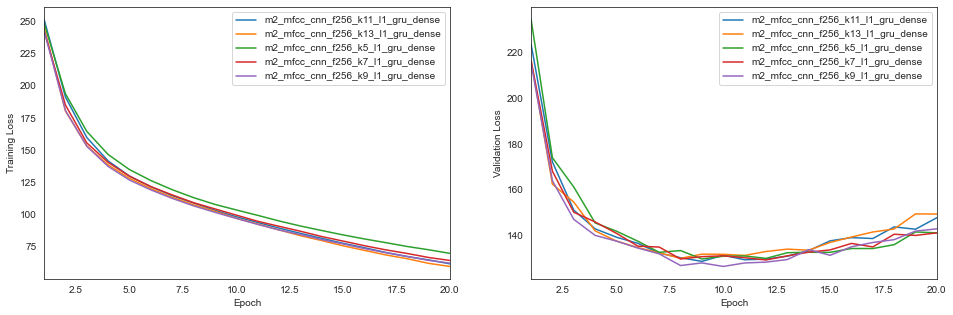

In [52]:
# plot model 2 variants
compare_models([m for m in all_pickles if 'm2' in m])

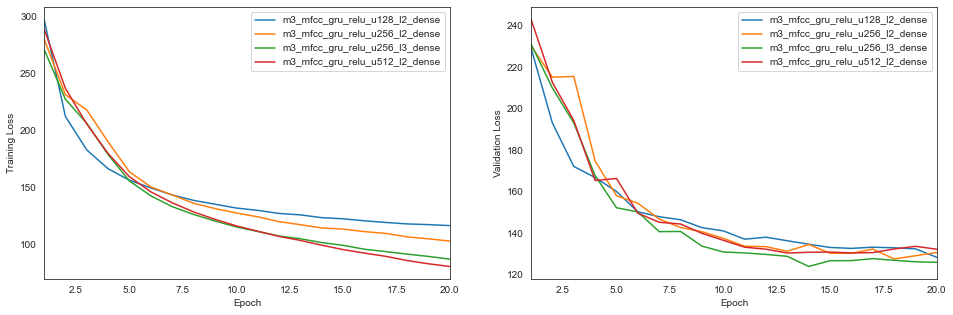

In [53]:
# plot model 3 variants
compare_models([m for m in all_pickles if 'm3' in m])

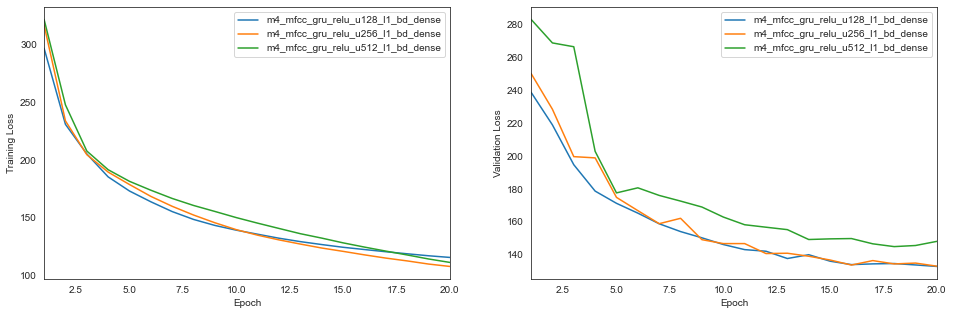

In [54]:
# plot model 4 variants
compare_models([m for m in all_pickles if 'm4' in m])

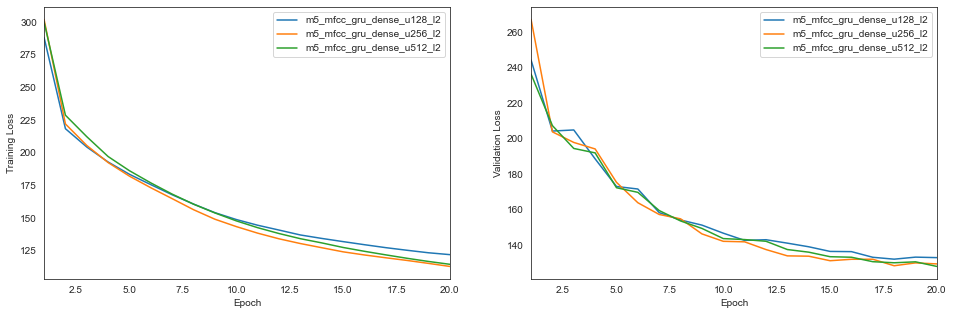

In [55]:
# plot model 5 variants
compare_models([m for m in all_pickles if 'm5' in m])

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

| Model | Overview |
|:-----:|:---------|
| `m0`  | The variants from this model type are unable to learn and show high training and validation loss because of their low complexity relative to the one from the data. The use of *Spectrogram* and *MFCC* features leads to equivalent results, however, the latter reduces the model footprint significantly. Based on these results, `mfcc_gru` is selected as the reference for `m0` and all subsequent model generations use *MFCC* features. |
| `m1`  | This model type defines a *baseline* configuration using *GRU* with 256 hidden *units* and *ReLU* activation. The choice of *GRU* is based on the evidence that it prevents vanishing gradients, common to *RNN*, and leads to equivalent or better results than *LSTM* for speech recognition \[[1](https://hal.archives-ouvertes.fr/hal-01633254)\]. Variations within this model type compare the effect from using other activation functions as well as the increase/decrease of hidden *units* by a 2x factor. The results show that models using *ReLU* have lower training and validation loss than the ones using *TanH*. Also, duplicating the hidden *units* slightly lowers the model bias and variance without overfitting at the expense of nearly quadruplicating the number of parameters. The reference for `m1` is `mfcc_gru_relu_u512_l1_dense` by a close margin with `mfcc_gru_relu_u256_l1_dense`, which would lead to lower model size. |
| `m2`  | The models from this type combine *CNN* with *RNN* using different *kernel size* values. All variants outperform the *baseline* configuration during learning by deriving features from the input data at different time steps in-line with the literature \[[2](https://ieeexplore.ieee.org/document/7178838)\], thus, reducing model bias. However, they tend to overfit the training dataset, where smaller *kernel size* values lead to lower model variance. The `mfcc_cnn_f128_k9_l1_gru_dense` is the reference for `m2` by a close margin with `mfcc_cnn_f128_k5_l1_gru_dense` and `mfcc_cnn_f128_k7_l1_gru_dense`. |
| `m3`  | The variants from this model type evaluate 2-3 levels of *GRU* layers and a 2x hidden *units* factor. In general, all configurations show equal or better overall performance than the *baseline* one. Regarding the architecture depth, using 3 recurrent layers with the *baseline* number of hidden *units* leads to the best results because it reduces model bias without compromising model variance. Nonetheless, it is worth noting that *deeper is not always better*, but network improvements by adding extra layers depend on how well features from previous ones represent the samples from the dataset \[[3](https://towardsdatascience.com/neural-network-why-deeper-isnt-always-better-2f862f40e2c4)\]. The reference for `m3` is `m3_mfcc_gru_relu_u256_l3_dense`. |
| `m4`  | This model type explores bidirectional *GRU* with different numbers of hidden *units*. The configurations with the same or half of the hidden *units* as the *baseline* slightly improved overall model performance in-line with the literature \[[4](https://arxiv.org/abs/1303.5778)\]. However, duplicating the number of hidden *units* requires more epochs to lower the model bias and degrades the model variance. The reference for `m4` is `m4_mfcc_gru_relu_u256_l1_bd_dense`. |
| `m5`  | These variants explore the effects of adding a short tail of fully connected layers after the recurrent neural network. It is inspired by the resulting architecture from the Machine Translation project \[[5](https://github.com/sdonatti/nd892-project-machine-translation)\]. The configurations with an equal or double number of hidden *units* with respect to the *baseline* slightly improved overall model performance. The reference for `m5` is `m5_mfcc_gru_dense_u256_l2` by a close margin with `m5_mfcc_gru_dense_u512_l2`, which has more trainable parameters. |

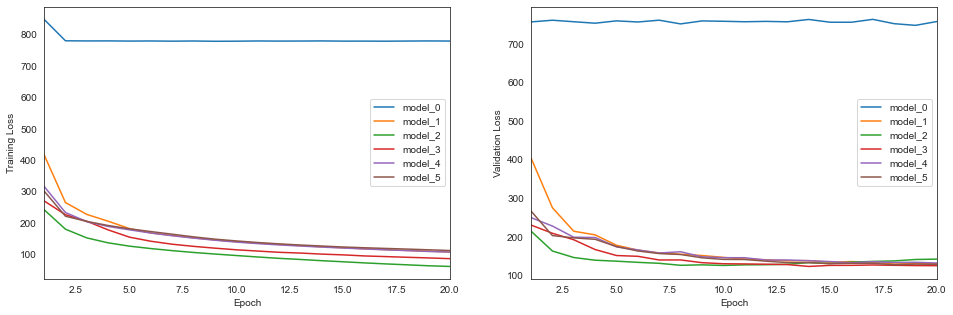

In [56]:
# plot model 0-5 references
compare_models([m for m in all_pickles if 'model' in m and 'model_end' not in m])

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [57]:
model_end = final_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
noise_input (GaussianNoise)  (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
cnn_1 (Conv1D)               (None, None, 256)         16896     
_________________________________________________________________
dp_cnn_1 (Dropout)           (None, None, 256)         0         
_________________________________________________________________
bn_cnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
cnn_2 (Conv1D)               (None, None, 256)         327936    
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [58]:
train_model(input_to_softmax=model_end, pickle_path='model_end.pickle',
            save_model_path='model_end.h5', spectrogram=False, epochs=40)

Epoch 1/40
101/101 [==============================] - 616s 6s/step - loss: 256.2435 - val_loss: 238.7776
Epoch 2/40
101/101 [==============================] - 651s 6s/step - loss: 206.7752 - val_loss: 188.3770
Epoch 3/40
101/101 [==============================] - 657s 7s/step - loss: 178.8857 - val_loss: 155.1518
Epoch 4/40
101/101 [==============================] - 653s 6s/step - loss: 159.1788 - val_loss: 141.6004
Epoch 5/40
101/101 [==============================] - 681s 7s/step - loss: 146.4930 - val_loss: 132.7210
Epoch 6/40
101/101 [==============================] - 687s 7s/step - loss: 136.6910 - val_loss: 122.9512
Epoch 7/40
101/101 [==============================] - 694s 7s/step - loss: 128.9503 - val_loss: 118.7154
Epoch 8/40
101/101 [==============================] - 785s 8s/step - loss: 122.9343 - val_loss: 113.2651
Epoch 9/40
101/101 [==============================] - 701s 7s/step - loss: 117.0641 - val_loss: 110.8166
Epoch 10/40
101/101 [==============================] - 

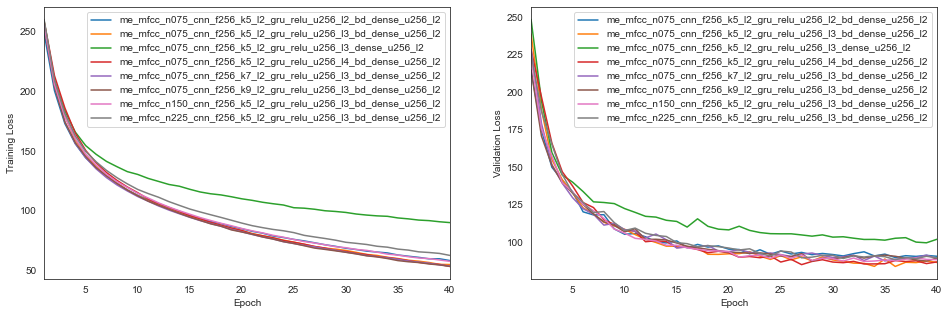

In [59]:
# compare all model end candidates
candidates = [m for m in all_pickles if 'me' in m]
if candidates:
    compare_models(candidates)

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

| Model | Overview |
|:-----:|:---------|
| `me`  | The final model is a *CNN* + *GRU* + *DNN* architecture based on the hyperparameter configurations of previous variants from models 1-5 with the best results together with three additional components. The first one is the perturbation of the input data using *Gaussian Noise* with a standard deviation of 0.075 and followed by batch normalization \[[4](https://arxiv.org/abs/1303.5778)\]. The second one is the introduction of an extra *Convolution* layer with *same padding* and *single stride* to generate additional features from the perturbed input data \[[6](https://arxiv.org/abs/1810.02364)\]. The third one is the use of *Dropout* in each module after the activation function to prevent the model from overfitting to the training dataset with a factor of 0.25 for the *CNN* / *RNN* and 0.5 for the *DNN* \[[7](https://adriangcoder.medium.com/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b)\]. Finally, the choice of hyperparameter values is validated with the generation and cross-comparison of the most promising *CNN* + *GRU* + *DNN* candidates derived from 3x input noise values, 3x convolution filter sizes, and 4x layer configurations. The reference for `me` is selected to the variant from model candidate `me_mfcc_n075_cnn_f256_k5_l2_gru_relu_u256_l3_bd_dense_u256_l2` because it reaches a low model bias and variance without overfitting to the training dataset. |

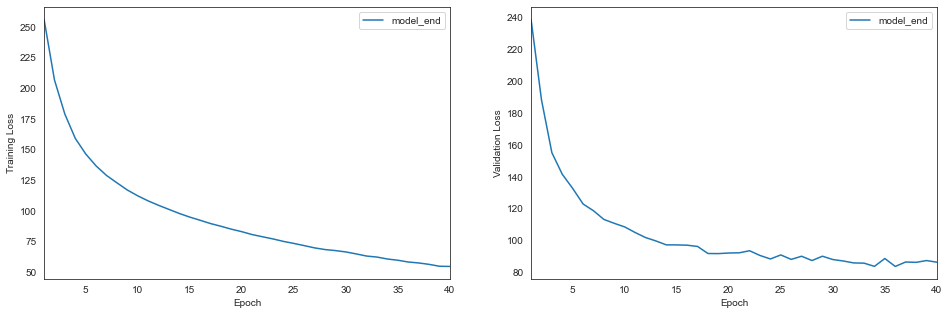

In [60]:
# plot model end reference
compare_models([m for m in all_pickles if 'model_end' in m])

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [61]:
import numpy as np
np.random.seed(42)

from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio


def get_predictions(index, partition, input_to_softmax, model_path, spectrogram=False):
    """
    Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=spectrogram)
    data_gen.load_train_data()
    data_gen.load_validation_data()

    # obtain the true transcription and the audio features
    if partition == 'validation':
        transcription = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcription = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition! Must be "train" or "validation"')

    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])]
    pred_ints = (K.eval(K.ctc_decode(prediction, output_length)[0][0])+1).flatten().tolist()

    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n\n{}'.format(transcription))
    print('-'*80)
    print('Predicted transcription:\n\n{}'.format(''.join(int_sequence_to_text(pred_ints))))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [62]:
get_predictions(index=0, partition='train', input_to_softmax=final_model(), model_path='results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
noise_input (GaussianNoise)  (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
cnn_1 (Conv1D)               (None, None, 256)         16896     
_________________________________________________________________
dp_cnn_1 (Dropout)           (None, None, 256)         0         
_________________________________________________________________
bn_cnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
cnn_2 (Conv1D)               (None, None, 256)         327936    
__________

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [63]:
get_predictions(index=0, partition='validation', input_to_softmax=final_model(), model_path='results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
noise_input (GaussianNoise)  (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
cnn_1 (Conv1D)               (None, None, 256)         16896     
_________________________________________________________________
dp_cnn_1 (Dropout)           (None, None, 256)         0         
_________________________________________________________________
bn_cnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
cnn_2 (Conv1D)               (None, None, 256)         327936    
__________

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!

<a id='optional'></a>
## Optional: Extend model end using more data

Re-train the final model with the set of 100 hours "clean" speech [dataset](https://www.openslr.org/resources/12/train-clean-100.tar.gz) and evaluate it using the same benchmark test set as before.

In [64]:
model_end_t100 = final_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
noise_input (GaussianNoise)  (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
cnn_1 (Conv1D)               (None, None, 256)         16896     
_________________________________________________________________
dp_cnn_1 (Dropout)           (None, None, 256)         0         
_________________________________________________________________
bn_cnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
cnn_2 (Conv1D)               (None, None, 256)         327936    
__________

In [65]:
train_model(input_to_softmax=model_end_t100, pickle_path='model_end_t100.pickle', verbose=1,
            save_model_path='model_end_t100.h5', spectrogram=False, epochs=40, train_json='train-100_corpus.json')

Epoch 1/40
268/268 [==============================] - 546s 2s/step - loss: 247.6814 - val_loss: 171.2238
Epoch 2/40
268/268 [==============================] - 535s 2s/step - loss: 176.0625 - val_loss: 128.3967
Epoch 3/40
268/268 [==============================] - 537s 2s/step - loss: 148.8331 - val_loss: 108.2328
Epoch 4/40
268/268 [==============================] - 536s 2s/step - loss: 133.8226 - val_loss: 97.8980
Epoch 5/40
268/268 [==============================] - 537s 2s/step - loss: 123.9104 - val_loss: 92.9116
Epoch 6/40
268/268 [==============================] - 534s 2s/step - loss: 117.0868 - val_loss: 84.6353
Epoch 7/40
268/268 [==============================] - 534s 2s/step - loss: 110.9990 - val_loss: 85.8333
Epoch 8/40
268/268 [==============================] - 535s 2s/step - loss: 106.5795 - val_loss: 79.9681
Epoch 9/40
268/268 [==============================] - 533s 2s/step - loss: 102.3651 - val_loss: 78.0836
Epoch 10/40
268/268 [==============================] - 536s 2

In [66]:
get_predictions(index=0, partition='train', input_to_softmax=final_model(), model_path='results/model_end_t100.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
noise_input (GaussianNoise)  (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
cnn_1 (Conv1D)               (None, None, 256)         16896     
_________________________________________________________________
dp_cnn_1 (Dropout)           (None, None, 256)         0         
_________________________________________________________________
bn_cnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
cnn_2 (Conv1D)               (None, None, 256)         327936    
__________

In [67]:
get_predictions(index=0, partition='validation', input_to_softmax=final_model(), model_path='results/model_end_t100.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
noise_input (GaussianNoise)  (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
cnn_1 (Conv1D)               (None, None, 256)         16896     
_________________________________________________________________
dp_cnn_1 (Dropout)           (None, None, 256)         0         
_________________________________________________________________
bn_cnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
cnn_2 (Conv1D)               (None, None, 256)         327936    
__________

Re-train the final model with the set of 360 hours "clean" speech [dataset](https://www.openslr.org/resources/12/train-clean-360.tar.gz) and evaluate it using the same benchmark test set as before.

In [68]:
model_end_t360 = final_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
noise_input (GaussianNoise)  (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
cnn_1 (Conv1D)               (None, None, 256)         16896     
_________________________________________________________________
dp_cnn_1 (Dropout)           (None, None, 256)         0         
_________________________________________________________________
bn_cnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
cnn_2 (Conv1D)               (None, None, 256)         327936    
__________

In [69]:
train_model(input_to_softmax=model_end_t360, pickle_path='model_end_t360.pickle', verbose=1,
            save_model_path='model_end_t360.h5', spectrogram=False, epochs=40, train_json='train-360_corpus.json')

Epoch 1/40
1027/1027 [==============================] - 1931s 2s/step - loss: 181.1979 - val_loss: 107.0574
Epoch 2/40
1027/1027 [==============================] - 1914s 2s/step - loss: 123.1191 - val_loss: 82.8190
Epoch 3/40
1027/1027 [==============================] - 1921s 2s/step - loss: 106.8366 - val_loss: 73.3235
Epoch 4/40
1027/1027 [==============================] - 1920s 2s/step - loss: 97.7597 - val_loss: 67.2231
Epoch 5/40
1027/1027 [==============================] - 1923s 2s/step - loss: 91.2559 - val_loss: 64.5849
Epoch 6/40
1027/1027 [==============================] - 1914s 2s/step - loss: 86.5825 - val_loss: 60.8763
Epoch 7/40
1027/1027 [==============================] - 1926s 2s/step - loss: 82.8115 - val_loss: 57.8816
Epoch 8/40
1027/1027 [==============================] - 1914s 2s/step - loss: 79.7750 - val_loss: 56.4356
Epoch 9/40
1027/1027 [==============================] - 1922s 2s/step - loss: 76.9694 - val_loss: 54.6791
Epoch 10/40
1027/1027 [===================

In [70]:
get_predictions(index=0, partition='train', input_to_softmax=final_model(), model_path='results/model_end_t360.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
noise_input (GaussianNoise)  (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
cnn_1 (Conv1D)               (None, None, 256)         16896     
_________________________________________________________________
dp_cnn_1 (Dropout)           (None, None, 256)         0         
_________________________________________________________________
bn_cnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
cnn_2 (Conv1D)               (None, None, 256)         327936    
__________

In [71]:
get_predictions(index=0, partition='validation', input_to_softmax=final_model(), model_path='results/model_end_t360.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
noise_input (GaussianNoise)  (None, None, 13)          0         
_________________________________________________________________
bn_input (BatchNormalization (None, None, 13)          52        
_________________________________________________________________
cnn_1 (Conv1D)               (None, None, 256)         16896     
_________________________________________________________________
dp_cnn_1 (Dropout)           (None, None, 256)         0         
_________________________________________________________________
bn_cnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
cnn_2 (Conv1D)               (None, None, 256)         327936    
__________

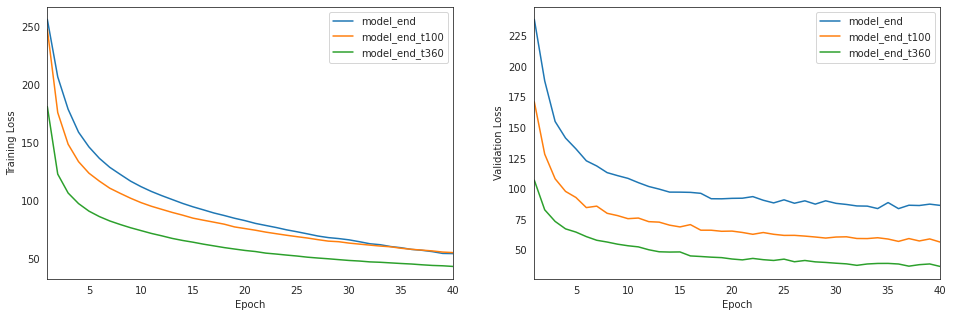

In [72]:
# obtain the paths for the saved model history
from glob import glob
all_pickles = sorted(glob(os.path.join('results','*.pickle')))
compare_models([m for m in all_pickles if 'model_end' in m])